# 400x Faster - Static & Distilled Embedding Models

<img src="./media/embedding_model.png" width=600>

[Img: Weaviate](https://weaviate.io/blog/how-to-choose-an-embedding-model)

Embedding models are used for a multitude of AI related applications, playing major parts in semantic textual similarity, semantic search, paraphrase mining, text classification, clustering, and more. But one major problem is that the best embedding models, while lightweight in comparison to things like LLMs, can still be many millions of parameters. For example, popular models like [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) and [bge-large-en-v1.5](https://huggingface.co/BAAI/bge-large-en-v1.5) are 22.7M & 335M parameters respectively.

Running these models then requires atleast some decent compute, and is commonly accelerated by GPUs. While small, scaling these workloads can get intensive and pricey. In this notebook we'll cover a few techniques (old and new!) that are used to squeeze efficiency out of embedding models, specifically:

**Static Embedding Models** and **Embedding Model Distillation**

## Static Embeddings

Static embeddings are no new concept, pre-dating the more popular transformer/attention based embedding models. Static embedding models are trained using techniques like:

<img src="./media/w2v_training.png" width=600>

[Word2Vec (CBOW, Skip-gram) In Depth](https://medium.com/@fraidoonomarzai99/word2vec-cbow-skip-gram-in-depth-88d9cc340a50)

**Skip-gram**: Predict surrounding words in a context window given a center word. (i.e. Word2Vec)

- Sentence: The quick brown fox jumps over the lazy dog
- Context Window: 3

| Center Word | Context Words (window = 3)                      |
| ----------- | ----------------------------------------------- |
| "the"       | "quick", "brown", "fox"                         |
| "quick"     | "the", "brown", "fox", "jumps"                  |
| "brown"     | "the", "quick", "fox", "jumps", "over"          |
| "fox"       | "the", "quick", "brown", "jumps", "over", "the" |
| "jumps"     | "quick", "brown", "fox", "over", "the", "lazy"  |
| "over"      | "brown", "fox", "jumps", "the", "lazy", "dog"   |
| "the"       | "fox", "jumps", "over", "lazy", "dog"           |
| "lazy"      | "jumps", "over", "the", "dog"                   |
| "dog"       | "over", "the", "lazy"                           |

**CBOW**: Predict the center word given surrounding words. (i.e. Word2Vec)

| Target Word | Context Words                                      |
| ----------- | -------------------------------------------------- |
| "the" (0)   | \["quick", "brown", "fox"]                         |
| "quick"     | \["the", "brown", "fox", "jumps"]                  |
| "brown"     | \["the", "quick", "fox", "jumps", "over"]          |
| "fox"       | \["the", "quick", "brown", "jumps", "over", "the"] |
| "jumps"     | \["quick", "brown", "fox", "over", "the", "lazy"]  |
| "over"      | \["brown", "fox", "jumps", "the", "lazy", "dog"]   |
| "the" (6)   | \["fox", "jumps", "over", "lazy", "dog"]           |
| "lazy"      | \["jumps", "over", "the", "dog"]                   |
| "dog"       | \["over", "the", "lazy"]                           |

**Matrix factorization**: Decompose word co-occurrence matrices. (i.e. GloVe)

|       | the | quick | brown | fox | jumps | over | lazy | dog |
| ----- | --- | ----- | ----- | --- | ----- | ---- | ---- | --- |
| the   | 0   | 2     | 2     | 2   | 2     | 2    | 1    | 1   |
| quick | 2   | 0     | 2     | 2   | 1     | 0    | 0    | 0   |
| brown | 2   | 2     | 0     | 2   | 2     | 1    | 0    | 0   |
| fox   | 2   | 2     | 2     | 0   | 2     | 2    | 1    | 0   |
| jumps | 2   | 1     | 2     | 2   | 0     | 2    | 2    | 1   |
| over  | 2   | 0     | 1     | 2   | 2     | 0    | 2    | 2   |
| lazy  | 1   | 0     | 0     | 1   | 2     | 2    | 0    | 2   |
| dog   | 1   | 0     | 0     | 0   | 1     | 2    | 2    | 0   |

Through running models across a vast corpus of text, researchers produced models that could efficiently convert words into semantically rich representations (i.e. an array of numbers that represents that word). Each cell in this matrix reflects how often a pair of words appeared within a given context window across the corpus. This all tended to follow the goal of capturing the distributional semantics of language based on the principle that words appearing in similar contexts tend to have similar meanings.

As quick additional context, before any of these training techniques can be applied, the input text corpus must undergo preprocessing. The first step in this pipeline is tokenization, which is the process of breaking down the raw text into a sequence of smaller units (or tokens). For traditional static embedding models like Word2Vec and GloVe, tokenization often involves standardizing the text—such as converting all characters to lowercase and removing punctuation—and then splitting the text by spaces. This typically results in individual words being treated as tokens.

<img src="./media/token.png" width=600>

[Tokenization — A complete guide](https://medium.com/@utkarsh.kant/tokenization-a-complete-guide-3f2dd56c0682)

Once the entire corpus has been tokenized, the set of unique tokens generated forms the basis for the model's **vocabulary**. Creating this fixed vocabulary generally involves:

1. Scanning the tokenized corpus to identify all unique word tokens.
2. Applying frequency thresholds to exclude very rare words, which might be noise or offer little semantic value.
3. Often, setting a maximum vocabulary size (e.g., the 50,000 to 1 million most frequent words) to keep the model manageable.
4. Incorporating special tokens, such as a token to represent out-of-vocabulary (OOV) words—words encountered later that were not part of the initial vocabulary.

This constructed vocabulary is then fundamental to how different models learn. Word2Vec-type models (CBOW and Skip-gram) use this vocabulary in their training objectives, examining probability distributions over all words in the vocabulary to maximize the accuracy of their predictions. In contrast, matrix factorization approaches like GloVe leverage the vocabulary to build a co-occurrence matrix. GloVe then directly decomposes these word co-occurrence statistics (derived from words in the vocabulary) into lower-dimensional representations. This all tended to follow the goal of capturing the distributional semantics of language based on the principle that words appearing in similar contexts tend to have similar meanings.

<img src="./media/embeddings.png" width=600>

[What are Vector Embeddings?](https://www.couchbase.com/blog/what-are-vector-embeddings/)

This style of static embedding model can thus be thought of as almost a lookup table, matching the individual words (or tokens) in a document to their respective numerical representaiton, learned via the aforementioned training on text content. Embeddings for phrases and documents were then calculated as an average of the individual word/token level embeddings generally through techniques like:

1. **Mean Pooling (Simple averaging)**: Taking the arithmetic mean of all word vectors in the document, giving equal weight to each word.
   ```
   document_embedding = (word_1_vector + word_2_vector + ... + word_n_vector) / n
   ```

2. **TF-IDF weighted averaging**: Weighting each word vector by its TF-IDF (term frequency - inverse document frequency) score to reduce the influence of common words and emphasize more distinctive terms.
   ```
   document_embedding = Σ(word_i_vector * tfidf_i) / Σ(tfidf_i)
   ```

3. **SIF (Smooth Inverse Frequency)**: A more sophisticated weighting scheme that combines word frequency with a parameter to smooth the weights, then removes the first principal component to eliminate common discourse elements.

---
## Static Embeddings in Action

One of the seminal works that pioneered vector embeddings in NLP was [Word2Vec (2013)](https://arxiv.org/pdf/1301.3781). Let's show some examples of this in action:

In [16]:
from staticvectors import StaticVectors
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Helper: print first few values of a vector
def print_vector(name, vec, num=10):
    snippet = ", ".join(f"{v:.4f}" for v in vec[:num])
    print(f"{name}: [{snippet}, ...]")

# Load static embedding model
w2v = StaticVectors("neuml/word2vec")

### Get Vector for "King"

In [17]:
# Get vectors
king_vec = w2v.embeddings(["king"])[0]
print_vector("king", king_vec)

king: [0.0434, 0.0103, 0.0030, 0.0481, -0.0088, -0.0124, 0.0385, -0.0683, 0.0177, 0.1252, ...]


### Get Vector for "Man"

In [18]:
man_vec = w2v.embeddings(["man"])[0]
print_vector("man", man_vec)

man: [0.1412, 0.0566, 0.0150, -0.0359, 0.0389, -0.0179, -0.0858, 0.0030, 0.0621, 0.0008, ...]


### Get Vector for "Woman"

In [20]:
woman_vec = w2v.embeddings(["woman"])[0]
print_vector("woman", woman_vec)

woman: [0.0916, -0.0291, -0.0388, -0.0405, 0.0445, -0.0405, -0.0430, 0.0097, 0.0421, 0.0183, ...]


### Get Vector for "Queen"

In [22]:
queen_vec = w2v.embeddings(["queen"])[0]
print_vector("queen", queen_vec)

queen: [0.0017, -0.0474, -0.0229, 0.0408, 0.0435, -0.0293, -0.0235, -0.0716, -0.0651, 0.0184, ...]


### Observe Similarities

Now that our words are represented as high dimensional arrays, we can look at the distance or angle between them to see how "semantically" similar the ideas are. The most popular way of calculating this is via cosine similarity

<img src="./media/cos_similarity.png" width=600>

[Machine Learning Fundamentals: Cosine Similarity and Cosine Distance](https://medium.com/geekculture/cosine-similarity-and-cosine-distance-48eed889a5c4)

In [27]:
similarity = cosine_similarity([queen_vec], [king_vec])[0][0]
print(f"\nSimilarity between queen and king: {similarity:.4f}")

similarity = cosine_similarity([man_vec], [woman_vec])[0][0]
print(f"\nSimilarity between man and woman: {similarity:.4f}")

similarity = cosine_similarity([king_vec], [man_vec])[0][0]
print(f"\nSimilarity between king and man: {similarity:.4f}")

similarity = cosine_similarity([queen_vec], [woman_vec])[0][0]
print(f"\nSimilarity between queen and woman: {similarity:.4f}")

similarity = cosine_similarity([king_vec], [woman_vec])[0][0]
print(f"\nSimilarity between king and woman: {similarity:.4f}")

similarity = cosine_similarity([queen_vec], [man_vec])[0][0]
print(f"\nSimilarity between queen and man: {similarity:.4f}")


Similarity between queen and king: 0.6511

Similarity between man and woman: 0.7664

Similarity between king and man: 0.2294

Similarity between queen and woman: 0.3162

Similarity between king and woman: 0.1285

Similarity between queen and man: 0.1666


One of the most popular examples of embedding based math is visually showing the "concepts" being added and subtracted out, and how they affect the final representation. Let's visually examine how:

`vector("king") - vector("man") + vector("woman") ≈ vector("queen")`

In [24]:
from staticvectors import StaticVectors
import numpy as np
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from sklearn.decomposition import PCA

# Initialize the notebook for Plotly
init_notebook_mode(connected=True)

# Initialize the model
w2v = StaticVectors("neuml/word2vec")

# Words to include in our visualization
words = ["king", "queen", "man", "woman", "prince", "princess", 
         "boy", "girl", "father", "mother", "son", "daughter"]


# Get embeddings for all words
embeddings = w2v.embeddings(words)

# Get indices for our key words
king_idx = words.index("king")
man_idx = words.index("man")
woman_idx = words.index("woman")
queen_idx = words.index("queen")

# Get vectors for key words
king_vec = embeddings[king_idx]
man_vec = embeddings[man_idx]
woman_vec = embeddings[woman_idx]
queen_vec = embeddings[queen_idx]

# Calculate the intermediate and result vectors
king_minus_man_vec = king_vec - man_vec
result_vec = king_minus_man_vec + woman_vec

# Add the intermediate and result vectors to our data
words.append("king-man")
words.append("king-man+woman")
embeddings = np.vstack([embeddings, king_minus_man_vec.reshape(1, -1), result_vec.reshape(1, -1)])

# Reduce dimensionality to 3D using PCA
pca = PCA(n_components=3)
vis_dims = pca.fit_transform(embeddings)

# Create color mapping - add the king-man point
colors = {
    "king": "blue",
    "queen": "red",
    "man": "blue",
    "woman": "red",
    "prince": "blue",
    "princess": "red",
    "boy": "blue",
    "girl": "red",
    "father": "blue",
    "mother": "red",
    "son": "blue",
    "daughter": "red",
    "king-man": "purple",
    "king-man+woman": "green",
}


# Create the scatter plot for words
trace = go.Scatter3d(
    x=vis_dims[:, 0],
    y=vis_dims[:, 1],
    z=vis_dims[:, 2],
    mode='markers+text',
    marker=dict(
        size=8,
        color=[colors[word] for word in words],
        opacity=0.8
    ),
    text=words,
    textposition="top center",
    hoverinfo='text',
    name='Words'
)

# Get the 3D PCA coordinates for our key points
king_pos = vis_dims[king_idx]
man_pos = vis_dims[man_idx]
woman_pos = vis_dims[woman_idx]
queen_pos = vis_dims[queen_idx]
king_minus_man_pos = vis_dims[-2]  # Second to last point is our king-man vector
result_pos = vis_dims[-1]  # The last point is our result vector

# Create the "king - man" arrow (from king to king-man)
arrow1 = go.Scatter3d(
    x=[king_pos[0], king_minus_man_pos[0]],
    y=[king_pos[1], king_minus_man_pos[1]],
    z=[king_pos[2], king_minus_man_pos[2]],
    mode='lines',
    line=dict(color='gray', width=4, dash='dash'),
    name='king - man'
)

# Create the "+ woman" arrow (from king-man to result)
arrow2 = go.Scatter3d(
    x=[king_minus_man_pos[0], result_pos[0]],
    y=[king_minus_man_pos[1], result_pos[1]],
    z=[king_minus_man_pos[2], result_pos[2]],
    mode='lines',
    line=dict(color='gray', width=4, dash='dash'),
    name='+ woman'
)

# Create the final arrow from result to queen (to show how close they are)
arrow3 = go.Scatter3d(
    x=[result_pos[0], queen_pos[0]],
    y=[result_pos[1], queen_pos[1]],
    z=[result_pos[2], queen_pos[2]],
    mode='lines',
    line=dict(color='green', width=4),
    name='≈ queen'
)

# Create the layout
layout = go.Layout(
    title="Word Analogy Visualization: king - man + woman ≈ queen",
    scene=dict(
        aspectmode='cube',
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
    ),
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        x=0.9,
        y=0.9,
        traceorder="normal",
        font=dict(size=12),
        bgcolor="rgba(255, 255, 255, 0.5)"
    ),
    hovermode='closest'
)

# Create the figure and display
fig = go.Figure(data=[trace, arrow1, arrow2, arrow3], layout=layout)
fig.show()

*Note: Chart doesn't render on github*

---

While these static embeddings are useful, one of the biggest issues they suffer from is `polysemy`, or the coexistence of many possible meanings for a word or phrase.

<img src="./media/polysemy.png" width=600>

Since the embeddings are not dynamic or contextual with static embedding models (duh), we fail to capture the nuances of words meanings used broadly. However, this was all changed with the next generation of:

## Transformer Based Embedding Models

<img src="./media/attention.png" width=600>

While static embedding models remained popular, the transformer architecture changed the game by implementing the attention mechanism, allowing token level encodings to change based on the context of the words around it. 

While we won't be going deep into transformer representations in this notebook, if you wish to learn more about sentence transformers and embedding models, check out my other resource [BERT: The Most Used AI Model You Haven't Heard Of](https://www.youtube.com/watch?v=n_UQ0e0fBIA)!

In the meantime, we can visualize the difference in vector representations for the two sentences using `bert-base-uncased`:
1. "I went to the bank to withdraw some money"
2. "We all swam down to the muddy river bank"

and note how the different words contextually affect the word bank:

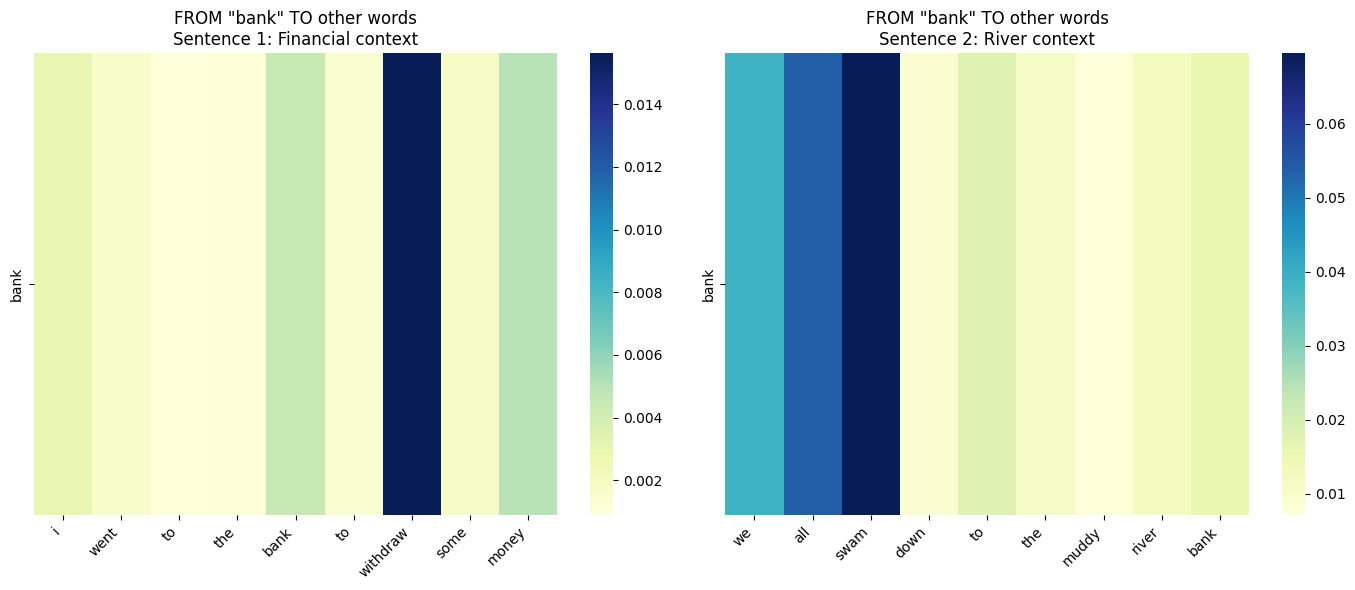

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import seaborn as sns

# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_hidden_states=True, output_attentions=True, attn_implementation="eager")

# Two separate sentences
sentence1 = "I went to the bank to withdraw some money"
sentence2 = "We all swam down to the muddy river bank"

# Process first sentence
tokens1 = tokenizer.tokenize(sentence1)
marked_text1 = ["[CLS]"] + tokens1 + ["[SEP]"]
indexed_tokens1 = tokenizer.convert_tokens_to_ids(marked_text1)
segments_ids1 = [1] * len(marked_text1)
tokens_tensor1 = torch.tensor([indexed_tokens1])
segments_tensors1 = torch.tensor([segments_ids1])

# Process second sentence
tokens2 = tokenizer.tokenize(sentence2)
marked_text2 = ["[CLS]"] + tokens2 + ["[SEP]"]
indexed_tokens2 = tokenizer.convert_tokens_to_ids(marked_text2)
segments_ids2 = [1] * len(marked_text2)
tokens_tensor2 = torch.tensor([indexed_tokens2])
segments_tensors2 = torch.tensor([segments_ids2])

# Get embeddings for both sentences
model.eval()
with torch.no_grad():
    outputs1 = model(tokens_tensor1, segments_tensors1)
    hidden_states1 = outputs1.hidden_states
    token_embeddings1 = hidden_states1[-1].squeeze()
    attention1 = outputs1.attentions[-1].squeeze().numpy()
    
    outputs2 = model(tokens_tensor2, segments_tensors2)
    hidden_states2 = outputs2.hidden_states
    token_embeddings2 = hidden_states2[-1].squeeze()
    attention2 = outputs2.attentions[-1].squeeze().numpy()

# Extract content attention matrices (excluding [CLS] and [SEP])
content_attention1 = attention1[att_head][1:-1, 1:-1]
content_attention2 = attention2[att_head][1:-1, 1:-1]

# Find indices of "bank" in both sentences
bank_idx1 = content_tokens1.index("bank")
bank_idx2 = content_tokens2.index("bank")

# Create visualizations specifically for the "bank" token
att_head = 0  # You can change this to visualize different attention heads

# VISUALIZATION 1: Attention FROM "bank" TO all other tokens
plt.figure(figsize=(14, 6))

# Sentence 1: Bank's attention to other tokens
plt.subplot(1, 2, 1)
bank_attention1 = content_attention1[bank_idx1].reshape(1, -1)
sns.heatmap(bank_attention1,
            xticklabels=content_tokens1,
            yticklabels=["bank"],
            cmap="YlGnBu")
plt.title('FROM "bank" TO other words')
plt.xticks(rotation=45, ha='right')

# Sentence 2: Bank's attention to other tokens
plt.subplot(1, 2, 2)
bank_attention2 = content_attention2[bank_idx2].reshape(1, -1)
sns.heatmap(bank_attention2,
            xticklabels=content_tokens2,
            yticklabels=["bank"],
            cmap="YlGnBu")
plt.title('FROM "bank" TO other words')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Thus, looking at the cosine similarity between both banks within these embeddings we see a limited similarity

In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Get embeddings for "bank" in both contexts
bank_embedding1 = content_embeddings1[bank_idx1].numpy().reshape(1, -1)
bank_embedding2 = content_embeddings2[bank_idx2].numpy().reshape(1, -1)

# Calculate cosine similarity between the two "bank" embeddings
similarity = cosine_similarity(bank_embedding1, bank_embedding2)[0][0]

print("Cosine similarity between both 'bank's:", similarity)

Cosine similarity between both 'bank's: 0.29626682


But if we add a third sentence including bank in a financial and seperate out the bank representation:

In [11]:
# Add a third sentence with "bank" in a financial context
sentence3 = "The bank manager approved my loan application"

# Process third sentence
tokens3 = tokenizer.tokenize(sentence3)
marked_text3 = ["[CLS]"] + tokens3 + ["[SEP]"]
indexed_tokens3 = tokenizer.convert_tokens_to_ids(marked_text3)
segments_ids3 = [1] * len(marked_text3)
tokens_tensor3 = torch.tensor([indexed_tokens3])
segments_tensors3 = torch.tensor([segments_ids3])

# Get embeddings for the third sentence
model.eval()
with torch.no_grad():
    outputs3 = model(tokens_tensor3, segments_tensors3)
    hidden_states3 = outputs3.hidden_states
    token_embeddings3 = hidden_states3[-1].squeeze()

# Extract content tokens and embeddings for the third sentence
content_tokens3 = tokens3
content_embeddings3 = token_embeddings3[1:-1]  # Skip first and last

# Find index of "bank" in third sentence
bank_idx3 = content_tokens3.index("bank")

# Get embedding for "bank" in the third context
bank_embedding3 = content_embeddings3[bank_idx3].numpy().reshape(1, -1)

# Calculate cosine similarities
similarity_1_3 = cosine_similarity(bank_embedding1, bank_embedding3)[0][0]

print("Cosine similarity between first sentence 'bank' and new 'bank':", similarity_1_3)


Cosine similarity between first sentence 'bank' and new 'bank': 0.8107918


It's much more similar!

---
## Back to Static - A Modern Revisit

But as mentioned earlier, while transormer based embedding models boast impressive contextual performance, they come with the downside of requiring magnitudes more compute to calculate. This is where we can revisit static embeddings. While it's impossible to solve the problem of polysemy with static embeddings, we can use modern techniques to train much more robust models.

This is highlighted in the recent blog post and model releases by Tom Aarsen, [Train 400x faster Static Embedding Models with Sentence Transformers](https://huggingface.co/blog/static-embeddings)

In this he provides the overview for data selection and training methodology for an english retrieval, and multilingual similarity model. Impressively, with new data and new techniques he is able to achieve a model that outperforms all prior static embedding models and BM25, while maintaining the benefits of blazing fast speeds

<img src="./media/nano_beir_vs_speed_gpu.png" width=600>

The main innovation is using contrastive learning, a technique we've seen with aligning multimodal representations in models like CLIP or enabling interchangable text & Audio/Video/Image understanding in LLMs. At its core, this learning method in embedding models calculates similarity between pairs (or more) of text sequences. The inputs are encoded into embeddings, their similarity is measured, and the model is trained to position semantically related inputs near each other in the embedding space, while distancing unrelated inputs. This creates a meaningful geometric arrangement where proximity indicates semantic relatedness."

<img src="./media/contrast.png" width=600>

[Understanding Deep Learning Algorithms that Leverage Unlabeled Data, Part 2: Contrastive Learning](https://ai.stanford.edu/blog/understanding-contrastive-learning/)

In Tom's approach, this is implemented using [MultipleNegativesRankingLoss](https://sbert.net/docs/package_reference/sentence_transformer/losses.html#multiplenegativesrankingloss). In this approach, for each anchor sample, you have one positive sample (that should be close to the anchor) and multiple negative samples (that should be distant from the anchor). The model is trained to rank the positive sample higher (more similar) than all the negative samples.

Let's take a look at a truncated sample of one of the data entries for an example from [pubmedqa](https://huggingface.co/datasets/sentence-transformers/pubmedqa), a dataset for biomedical research question and answering that follows this format:

| Anchor                                                                                          | Positive                                                                                                                | Negative 1                                                                                                      | Negative 2                                                                                                      | Negative 3                                                                                                      | Negative 4                                                                                                      | Negative 5                                                                                                      |
|--------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------|
| Does the severity of obstructive sleep apnea predict patients requiring high continuous positive airway pressure? | Three hundred fifty-three consecutive obstructive sleep apnea (OSA) patients who had a successful manual CPAP titration in our sleep disorders unit. | Obstructive sleep apnea (OSA) increases the risk of cardiovascular disease (CVD) and has been reported to be associated with chronic kidney disease (CKD). Recent studies have demonstrated that cystati... | We prospectively included 194 obstructive sleep apnea syndrome patients without cardiovascular disease (mean age 56.5±12.5 years) who were undergoing sleep tests. An overnight full laboratory polisomn... | Exercise limitation is an important issue in patients with chronic obstructive pulmonary disease (COPD), and it often co-exists with obstructive sleep apnoea (overlap syndrome). This study examined th... | The purpose of present study was to evaluate the acute effects of bi-level positive airway pressure (BiPAP) on heart rate variability (HRV) of stable chronic obstructive pulmonary disease patients (CO... | Obstructive sleep apnea is a risk factor for dyslipidemia and atherosclerosis, which have been attributed to chronic intermittent hypoxia (CIH). Intermittent hypoxia inhibits a key enzyme of lipoprote... |

So during training, the embedding model will learn to better represent the anchor text closer to the positive text, and further away from the negatives. Tom also used Matryoshka Representation Learning, a technique to frontload representation in the earlier dimensions of embeddings. I have a more complete explanation of MRL training in action in my [resource regarding fine tuning embedding models here!](https://youtu.be/v28Pu7hsJ0s?si=YPt82Si7o9yXtCh5)

Let's give the [multi lingual similarity model](https://huggingface.co/sentence-transformers/static-similarity-mrl-multilingual-v1) a shot:

In [17]:
from sentence_transformers import SentenceTransformer

# Download from the 🤗 Hub
model = SentenceTransformer("sentence-transformers/static-similarity-mrl-multilingual-v1", device="cpu")

# Run inference
sentences = [
    'It is known for its dry red chili powder.',
    'It is popular for dried red chili powder.',
    'These monsters will move in large groups.',
]

embeddings = model.encode(sentences)

print("Embedding Shape:", embeddings.shape)

# Get the similarity scores for the embeddings
similarities = model.similarity(embeddings, embeddings)
print("\nSimilarities:", similarities)

Embedding Shape: (3, 1024)

Similarities: tensor([[ 1.0000,  0.8388, -0.0012],
        [ 0.8388,  1.0000,  0.0445],
        [-0.0012,  0.0445,  1.0000]])


What's notable about this, is that we're able to push performance of embedding for common tasks like similarity and retrieval (the other static embedding model trained) above classic ranking algorithms like BM25 and getting close to the performance of some of the most used sentence transformers like [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) within 6 percentage points on NanoBEIR NDCG@10 evaluations (**0.5032** vs **0.5623** respectively).

All the while allowing for **107419.51** sentences per second to be computed on CPU, whilst the competitor all-MiniLM-L6-v2 can only run **1739.31** per second. (61.8X Faster!) These advances are significant, as this speedup can be incredibly beneficial for large scale production settings where the small accuracy tradeoff may be worthwhile. Additionally, it may be that further innovations in static embedding model training could push this further.

I gave this a shot by recreating the training, but this time using the [ModernBERT-base](https://huggingface.co/answerdotai/ModernBERT-base) tokenizer instead of [bert-base-uncased](https://huggingface.co/google-bert/bert-base-uncased) like the original:

<img src="./media/myloss.png" width=600>

But only managed to push my NanoBEIR NDCG@10 (same primary metric as the prior) to **0.4791**. A few percentage points down- regardless you can still check out the model at [AdamLucek/static-retrieval-mrl-MBERT-base-en-v1](https://huggingface.co/AdamLucek/static-retrieval-mrl-MBERT-base-en-v1)!

---
## Embedding Model Distillation

However fun fully trained static embedding model's are, one trend that's picked up is converting existing contextual/transformer based model's into a static embedding model using [Model2Vec](https://github.com/MinishLab/model2vec)

<img src="./media/m2v.png" width=600>

M2V uses some surprisingly simple observations to do this conversion. The primary steps for converting a model are to:
1. Run every token in a model's vocabulary through the model and store the embedding
2. Reduce the dimensionality of the output embedding
3. Weight each embedding

Thus Model2Vec essentially bootstraps static embeddings from transformer models by creating a lookup table of vector representations, applying dimensionality reduction, and weighting tokens appropriately, without requiring extensive training.

While the 1st step here is relatively straightforward, steps 2 and 3 could use some additional light. We rely on PCA, or Principal Component Analysis, dimensionality reduction. 

<img src="./media/pca.png" width=600>

[Dimensionality Reduction: PCA, LDA, TSNE](https://www.123ofai.com/post/pca-lda-tsne-dimensionality-reduction)

PCA attempts to map high dimensional data to lower dimensional space while maintaining the geometric distribution of the data as best as possible. This means that we can take large embeddings and convert them into smaller embeddings with a minimal loss in the semantic meaning of these embeddings and their relationships to each other (i.e. taking a 1028D vector and converting it to 256D). This is also what we used to convert embeddings into 3 dimensions for our prior interactive graph!

PCA reduction in M2V helps to not only store more efficient and smaller vector representations, but can also help normalize and denoise the data from any high dimension model specific information, reduce any redundant learnings, and assist in generalizing a little more. So while we lose the specificity of the transformer based embedding, this will help make the token specific embedding more applicable to wider scenarios in a static setting where we won't have the luxury of context. 

<img src="./media/zipf.png" width=600>

[Model2Vec: Distill a Small Fast Model from any Sentence Transformer](https://huggingface.co/blog/Pringled/model2vec)

Finally, when considering that a static embedding of a sequence, document or sentence will simply be a pooled average of the individual token level embeddings, it is important to add in some form of weighting. While unable to do the "weighting" in a sense of how attention can, we know that some words in sentences will contribute much more to the overal meaning than others. I.e. in the sentence "The quick brown fox jumps over the lazy dog", subjects like fox and dog have much stronger contributions than articles like "the".

M2V uses a simplified version of smooth inverse frequency based on [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), which states that "when a list of measured values is sorted in decreasing order, the value of the n-th entry is often approximately inversely proportional to n." From wikipedia again, this is saying that "It is usually found that the most common word occurs approximately twice as often as the next common one, three times as often as the third most common, and so on." As most vocabularies are already frequency ordered lists, we can assume this to hold true and effectively downweight frequent words and upweight rare words using the already provided list.

So the Model2Vec algorithm applies this three step process using a given transformer embedding model and an optional vocabulary to quickly build a static embedding model based on it's inputs, let's take a look at this in action:

### Load and Distill Model

We'll be using [BAAI/bge-m3](https://huggingface.co/BAAI/bge-m3), a ~560M parameter multilingual sentence transformer model capable of processing sequences of up to 8192 tokens into 1024D vector representations

In [1]:
from model2vec.distill import distill

# Choose a Sentence Transformer model
base_model_name = "BAAI/bge-m3"

# Distill an output model with the chosen dimensions
distilled_model = distill(model_name=base_model_name, pca_dims=256)

python(32674) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Encoding tokens: 100%|████████████| 249999/249999 [04:48<00:00, 866.60 tokens/s]


### Save Model

In [2]:
distilled_model.save_pretrained("./models/bge-m3-distill")

### Load Base & Distilled Model for Comparison

In [3]:
from sentence_transformers import SentenceTransformer

reg_model = SentenceTransformer("BAAI/bge-m3", device="cpu")
m2v_model = SentenceTransformer("./models/bge-m3-distill", device="cpu")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

### Compare Sentence Similarity

Using a quick example from the english subset of [MLDR](https://huggingface.co/datasets/sentence-transformers/mldr), the dataset used to train BGE-M3.

In [11]:
sentences = [
    "What is Didier Ruef best known for as a photographer?", # Anchor
    "Didier Ruef (born 1961) is a Swiss documentary photographer best known for his portrayal of man and waste, recycle and sustainability, Africa, man and animals, Swiss alpine farmers and contemporary Switzerland.", # Positive
    "Hussein Shariffe (7th July, 1934 – 21st January 2005, Omdurman, Sudan) was a Sudanese filmmaker, painter, poet and university lecturer at the University of Khartoum. After years of schooling in Khartoum and Alexandria, Egypt, he studied Modern History and Fine Arts in England, where he had his first exhibition in London's Gallery One in 1957. Back in Sudan in the 1970s, he worked both at the Ministry of Culture and the Faculty of Arts at the University of Khartoum. From 1973, he started a second artistic career as filmmaker, producing several documentary films and cinematographic essays on subjects such as traditional rites or history in Sudan, as well as on life in exile during his later years in Cairo.", # Negative
]

In [12]:
embeddings = reg_model.encode(sentences)
embeddings_m2v = m2v_model.encode(sentences)

# Calculate similarity matrices for both models
similarities_reg = reg_model.similarity(embeddings, embeddings)
similarities_m2v = m2v_model.similarity(embeddings_m2v, embeddings_m2v)

In [40]:
print("===== Model Comparison =====")
print("\nBase Model:")
print("\nAnchor & Positive: ", similarities_reg[0][1].item())
print("Anchor & Negative: ", similarities_reg[0][2].item())
print("\n============================")
print("\nDistilled Model:")
print("\nAnchor & Positive: ", similarities_m2v[0][1].item())
print("Anchor & Negative: ", similarities_m2v[0][2].item())

===== Model Comparison =====

Base Model:

Anchor & Positive:  0.7573255300521851
Anchor & Negative:  0.3512013852596283


Distilled Model:

Anchor & Positive:  0.377685546875
Anchor & Negative:  0.1063232421875


While our direct computations are different, the expected result of higher similarity to the positive vs the negative holds true!

---
## Discussion

<img src="./media/similarity.png" width=800>

[NLP SIMILARITY: Use pretrained word embeddings for semantic similarity search with BERT Transformers](https://christianbernecker.medium.com/nlp-similarity-use-pretrained-word-embeddings-for-semantic-similarity-search-with-bert-4beaf7b6a148)

So while modern day embedding models based on transformers can create robust dynamic embeddings, applying new data and approaches to old techniques have found static embeddings working their way back into the stack. While the latest in research in this area begins to provide competitive output to some of the most used transformer models, but at a fraction of the parameters and resources required to run and up to 400x faster in comparison!